<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Jet_Classification_QMAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pennylane h5py --quiet

In [2]:
# Standard imports
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
@dataclass
class Config:
    SAMPLES: int = 20000         # Dataset size
    NUM_QUBITS: int = 8          # Number of qubits for PQC
    Q_DEPTH: int = 6             # Depth of quantum circuit
    ENCODING_SCHEME: str = 'angle'
    USE_ANALYTIC_GRADIENTS: bool = True
    CNN_OUTPUT_DIM: int = 512    # High-dimensional CNN features
    USE_PRETRAINED_CNN: bool = True  # Use ResNet18 for strong feature extraction
    INNER_STEPS: int = 8         # Inner-loop steps for adaptation
    INNER_LR: float = 0.003      # Inner-loop learning rate
    OUTER_LR: float = 0.0003     # Outer-loop learning rate
    META_TASK_TYPE: str = 'both' # Use both `pt` and `m0` for meta-task generation
    META_BIN_COUNT: int = 10     # Number of bins for meta-task generation
    META_TASK_STRATEGY: str = 'binning'
    SUPPORT_SIZE: int = 32       # Support set size
    QUERY_SIZE: int = 32         # Query set size
    EPOCHS: int = 20             # Number of epochs
    BATCH_SIZE: int = 32         # Batch size for DataLoader
    EVAL_METRICS: bool = True
    USE_TEST2: bool = True
    SAVE_BEST_MODEL: bool = True
    CHECKPOINT_DIR: str = '/content/drive/MyDrive/quark-gluon-checkpoints'

config = Config()

os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

In [4]:
class JetDataset(Dataset):
    """Custom Dataset for loading jet images, labels, and additional features."""
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray = None, m0: np.ndarray = None):
        self.X = X
        self.y = y
        self.pt = pt
        self.m0 = m0

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        return self.X[idx], self.y[idx]

def load_and_merge_datasets(config: Config) -> Tuple[Dataset, Dataset]:
    """Load and merge datasets for meta-task generation."""
    # Paths to datasets
    train_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    test1_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'
    test2_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n10000.hdf5'

    # Load train and test1 datasets
    with h5py.File(train_path, 'r') as f:
        X_train = f['X_jets'][:config.SAMPLES]
        y_train = f['y'][:config.SAMPLES]
        pt_train = f['pt'][:config.SAMPLES]
        m0_train = f['m0'][:config.SAMPLES]

    with h5py.File(test1_path, 'r') as f:
        X_test1 = f['X_jets'][:config.SAMPLES]
        y_test1 = f['y'][:config.SAMPLES]
        pt_test1 = f['pt'][:config.SAMPLES]
        m0_test1 = f['m0'][:config.SAMPLES]

    # Merge train and test1
    X_meta = np.concatenate([X_train, X_test1], axis=0)
    y_meta = np.concatenate([y_train, y_test1], axis=0)
    pt_meta = np.concatenate([pt_train, pt_test1], axis=0)
    m0_meta = np.concatenate([m0_train, m0_test1], axis=0)

    # Load test2 dataset
    with h5py.File(test2_path, 'r') as f:
        X_test2 = f['X'][:config.SAMPLES]  # Use 'X' instead of 'X_jets'
        y_test2 = f['y'][:config.SAMPLES]

    # Create datasets
    meta_dataset = JetDataset(X_meta, y_meta, pt_meta, m0_meta)
    test2_dataset = JetDataset(X_test2, y_test2)

    return meta_dataset, test2_dataset

# Load datasets
meta_dataset, test2_dataset = load_and_merge_datasets(config)

In [5]:
def generate_meta_tasks(
    dataset: Dataset,
    meta_task_type: str,
    bin_count: int,
    support_size: int,
    query_size: int,
    strategy: str = 'binning',
    num_tasks_per_bin: int = 3,  # Generate multiple tasks per bin
) -> List[Dict[str, Any]]:
    """
    Generate meta-tasks using both `pt` and `m0` features for diversity.
    """
    X, y = [], []
    for i in range(len(dataset)):
        X_sample, y_sample = dataset[i]
        X.append(X_sample)
        y.append(y_sample)
    X = np.array(X)
    y = np.array(y)

    meta_tasks = []
    bin_task_counts = []

    # Alternate between `pt` and `m0` for meta-task generation
    for feature_type in ['pt', 'm0']:
        feature = getattr(dataset, feature_type)
        bins = np.linspace(feature.min(), feature.max(), bin_count + 1)
        for i in range(len(bins) - 1):
            bin_indices = np.where((feature >= bins[i]) & (feature < bins[i + 1]))[0]
            if len(bin_indices) < support_size + query_size:
                continue

            class_0_indices = bin_indices[y[bin_indices] == 0]
            class_1_indices = bin_indices[y[bin_indices] == 1]

            if len(class_0_indices) < support_size // 2 or len(class_1_indices) < support_size // 2:
                continue

            for _ in range(num_tasks_per_bin):
                support_indices = np.concatenate([
                    np.random.choice(class_0_indices, support_size // 2, replace=False),
                    np.random.choice(class_1_indices, support_size // 2, replace=False)
                ])
                query_indices = np.concatenate([
                    np.random.choice(class_0_indices, query_size // 2, replace=False),
                    np.random.choice(class_1_indices, query_size // 2, replace=False)
                ])
                meta_tasks.append(
                    {
                        "support_X": torch.tensor(X[support_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                        "support_y": torch.tensor(y[support_indices], dtype=torch.long),
                        "query_X": torch.tensor(X[query_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                        "query_y": torch.tensor(y[query_indices], dtype=torch.long),
                    }
                )
            bin_task_counts.append(num_tasks_per_bin)

    print(f"Total meta-tasks generated: {len(meta_tasks)}")
    return meta_tasks
meta_tasks = generate_meta_tasks(
    meta_dataset,
    config.META_TASK_TYPE,
    config.META_BIN_COUNT,
    config.SUPPORT_SIZE,
    config.QUERY_SIZE,
    config.META_TASK_STRATEGY,
)

Total meta-tasks generated: 39


In [6]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_dim: int, num_qubits: int, use_pretrained: bool = False):
        super().__init__()
        self.use_pretrained = use_pretrained
        self.dropout = nn.Dropout(p=0.5)  # Dropout for regularization

        if use_pretrained:
            self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
            self.model.fc = nn.Sequential(
                nn.Linear(self.model.fc.in_features, output_dim),
                nn.ReLU(),
                nn.Dropout(p=0.5),  # Dropout after ResNet FC layer
                nn.Linear(output_dim, num_qubits)
            )
        else:
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(64 * 15 * 15, output_dim)
            self.fc2 = nn.Linear(output_dim, num_qubits)

    def forward(self, x):
        if self.use_pretrained:
            x = self.model(x)
            return x
        else:
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.dropout(x)  # Dropout after conv1
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.dropout(x)  # Dropout after conv2
            x = self.pool(torch.relu(self.conv3(x)))
            x = self.dropout(x)  # Dropout after conv3
            x = x.contiguous().view(x.size(0), -1)
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)  # Dropout after fc1
            x = self.fc2(x)
            return x

In [7]:
class PQCModel(nn.Module):
    def __init__(self, num_qubits, depth, encoding_scheme, use_analytic_gradients):
        super().__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.encoding_scheme = encoding_scheme
        self.use_analytic_gradients = use_analytic_gradients
        self.dev = qml.device("default.qubit", wires=num_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            if encoding_scheme == 'angle':
                for i in range(num_qubits):
                    qml.RY(inputs[i], wires=i)
            elif encoding_scheme == 'amplitude':
                qml.AmplitudeEmbedding(inputs, wires=range(num_qubits), normalize=True)
            else:
                raise ValueError("Invalid encoding scheme.")
            qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return qml.expval(qml.PauliZ(0))
        self.circuit = circuit
        self.weights = nn.Parameter(torch.randn(depth, num_qubits, 3))
        self.fc = nn.Linear(1, 2)

    def forward(self, x):
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, 1)
        for i in range(batch_size):
            outputs[i] = self.circuit(x[i], self.weights)
        logits = self.fc(outputs)
        return logits

In [8]:
class HybridModel(nn.Module):
    """Hybrid Quantum-Classical Model."""
    def __init__(self, cnn: nn.Module, pqc: nn.Module):
        super().__init__()
        self.cnn = cnn
        self.pqc = pqc

    def forward(self, x):
        # Pass input through the CNN feature extractor
        features = self.cnn(x)
        # Pass extracted features through the PQC
        logits = self.pqc(features)
        return logits

In [9]:
def inner_loop_adaptation(
    model: nn.Module,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    inner_steps: int,
    inner_lr: float,
) -> nn.Module:
    """
    Perform inner-loop adaptation on the support set.

    Args:
        model: The hybrid model to adapt.
        support_X: Support set inputs.
        support_y: Support set labels.
        inner_steps: Number of inner-loop optimization steps.
        inner_lr: Learning rate for inner-loop.

    Returns:
        Adapted model with updated parameters.
    """
    adapted_model = HybridModel(model.cnn, model.pqc)  # Clone the model
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(inner_steps):
        optimizer.zero_grad()
        logits = adapted_model(support_X)
        loss = loss_fn(logits, support_y)
        loss.backward()
        optimizer.step()

    return adapted_model

In [10]:
def outer_loop_meta_update(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    outer_lr: float,
    eval_metrics: bool,
) -> Dict[str, List[float]]:
    optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr, weight_decay=1e-4)  # Add weight decay
    loss_fn = nn.CrossEntropyLoss()

    meta_loss_history = []
    metrics_history = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}
    best_accuracy = 0.0

    for epoch in range(config.EPOCHS):
        meta_loss = 0.0
        epoch_metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}

        for task in meta_tasks:
            # Inner-loop adaptation
            adapted_model = inner_loop_adaptation(
                model,
                task["support_X"],
                task["support_y"],
                config.INNER_STEPS,
                config.INNER_LR,
            )

            # Evaluate on query set
            query_logits = adapted_model(task["query_X"])
            query_loss = loss_fn(query_logits, task["query_y"])
            meta_loss += query_loss.item()

            # Backpropagate meta-loss
            optimizer.zero_grad()
            query_loss.backward()
            optimizer.step()

            # Track per-task metrics
            if eval_metrics:
                preds = torch.argmax(query_logits, dim=1)
                accuracy = accuracy_score(task["query_y"].cpu(), preds.cpu())
                precision = precision_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                recall = recall_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                f1 = f1_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)

                epoch_metrics["accuracy"].append(accuracy)
                epoch_metrics["precision"].append(precision)
                epoch_metrics["recall"].append(recall)
                epoch_metrics["f1_score"].append(f1)

        # Store per-epoch meta-loss
        meta_loss /= len(meta_tasks)
        meta_loss_history.append(meta_loss)

        # Store average metrics for this epoch
        if eval_metrics:
            avg_accuracy = np.mean(epoch_metrics["accuracy"])
            avg_precision = np.mean(epoch_metrics["precision"])
            avg_recall = np.mean(epoch_metrics["recall"])
            avg_f1 = np.mean(epoch_metrics["f1_score"])

            metrics_history["accuracy"].append(avg_accuracy)
            metrics_history["precision"].append(avg_precision)
            metrics_history["recall"].append(avg_recall)
            metrics_history["f1_score"].append(avg_f1)

            # Save the best model based on accuracy
            if config.SAVE_BEST_MODEL and avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, "best_model.pth"))

        print(f"Epoch {epoch + 1}/{config.EPOCHS}, Meta-loss: {meta_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return {"meta_loss": meta_loss_history, **metrics_history}

In [11]:
# Instantiate the models
cnn_extractor = CNNFeatureExtractor(config.CNN_OUTPUT_DIM, config.NUM_QUBITS, config.USE_PRETRAINED_CNN)
pqc_model = PQCModel(config.NUM_QUBITS, config.Q_DEPTH, config.ENCODING_SCHEME, config.USE_ANALYTIC_GRADIENTS)
hybrid_model = HybridModel(cnn_extractor, pqc_model)

# Train the model
training_results = outer_loop_meta_update(
    hybrid_model, meta_tasks, config.OUTER_LR, config.EVAL_METRICS
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/20, Meta-loss: 0.6715, Accuracy: 0.5889
Epoch 2/20, Meta-loss: 0.6507, Accuracy: 0.6851
Epoch 3/20, Meta-loss: 0.6343, Accuracy: 0.7035
Epoch 4/20, Meta-loss: 0.6209, Accuracy: 0.7204
Epoch 5/20, Meta-loss: 0.6082, Accuracy: 0.7308
Epoch 6/20, Meta-loss: 0.5849, Accuracy: 0.7644
Epoch 7/20, Meta-loss: 0.5726, Accuracy: 0.7652
Epoch 8/20, Meta-loss: 0.5541, Accuracy: 0.7812
Epoch 9/20, Meta-loss: 0.5460, Accuracy: 0.7893
Epoch 10/20, Meta-loss: 0.5370, Accuracy: 0.7949
Epoch 11/20, Meta-loss: 0.5201, Accuracy: 0.8141
Epoch 12/20, Meta-loss: 0.5040, Accuracy: 0.8213
Epoch 13/20, Meta-loss: 0.4735, Accuracy: 0.8462
Epoch 14/20, Meta-loss: 0.4533, Accuracy: 0.8614
Epoch 15/20, Meta-loss: 0.4451, Accuracy: 0.8614
Epoch 16/20, Meta-loss: 0.4437, Accuracy: 0.8542
Epoch 17/20, Meta-loss: 0.4193, Accuracy: 0.8774
Epoch 18/20, Meta-loss: 0.4034, Accuracy: 0.8910
Epoch 19/20, Meta-loss: 0.3791, Accuracy: 0.8990
Epoch 20/20, Meta-loss: 0.3794, Accuracy: 0.8894


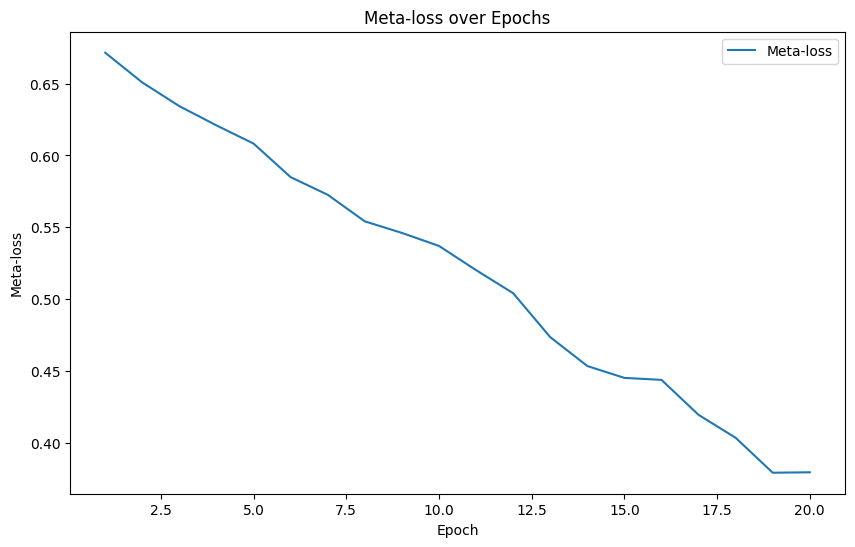

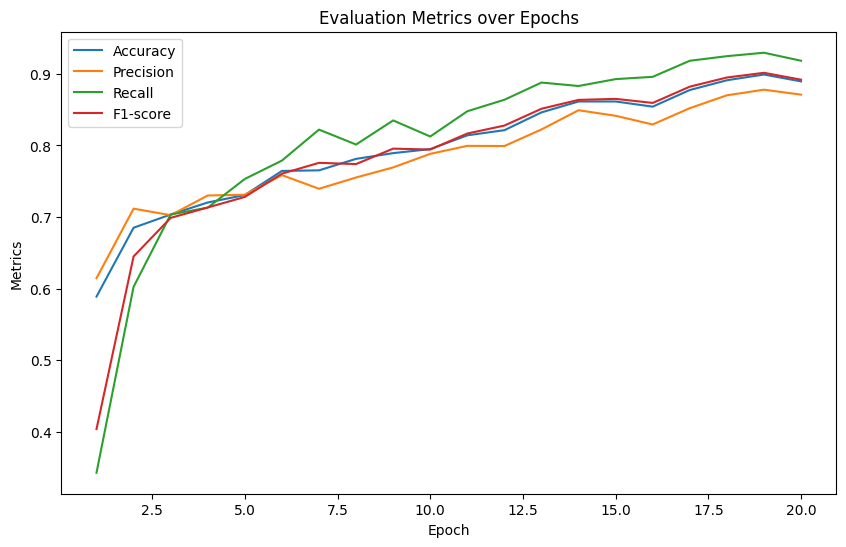

In [12]:
def plot_training_results(results: Dict[str, List[float]]):
    """
    Plot training results including meta-loss and evaluation metrics.

    Args:
        results: Dictionary containing meta-loss and evaluation metrics.
    """
    epochs = range(1, len(results["meta_loss"]) + 1)

    # Plot meta-loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["meta_loss"], label="Meta-loss")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title("Meta-loss over Epochs")
    plt.legend()
    plt.show()

    # Plot evaluation metrics
    if config.EVAL_METRICS:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, results["accuracy"], label="Accuracy")
        plt.plot(epochs, results["precision"], label="Precision")
        plt.plot(epochs, results["recall"], label="Recall")
        plt.plot(epochs, results["f1_score"], label="F1-score")
        plt.xlabel("Epoch")
        plt.ylabel("Metrics")
        plt.title("Evaluation Metrics over Epochs")
        plt.legend()
        plt.show()

plot_training_results(training_results)

Classification Report:
               precision    recall  f1-score   support

       Quark       0.53      0.48      0.51      5000
       Gluon       0.53      0.57      0.55      5000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



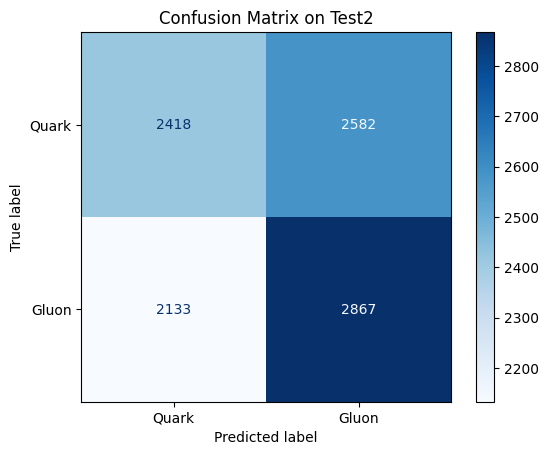

In [13]:
def evaluate_on_test2(model: nn.Module, test2_dataset: Dataset):
    """
    Evaluate the trained model on the test2 dataset.

    Args:
        model: The trained hybrid model.
        test2_dataset: The test2 dataset.

    Returns:
        None. Prints classification metrics and plots confusion matrix.
    """
    test2_loader = DataLoader(test2_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test2_loader:
            X_batch = X_batch.permute(0, 3, 1, 2)
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute classification metrics
    report = classification_report(
        all_labels,
        all_preds,
        target_names=["Quark", "Gluon"],
        labels=[0, 1],
        zero_division=0
    )
    print("Classification Report:\n", report)

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])  # Ensure 2x2 shape
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Quark", "Gluon"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix on Test2")
    plt.show()

if config.USE_TEST2:
    evaluate_on_test2(hybrid_model, test2_dataset)